# Randomized simulations

In [1]:
import numpy as np
import pandas as pd
import pyro
import torch
import matplotlib.pyplot as plt
from collections import defaultdict
from matplotlib.ticker import FormatStrFormatter
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from tapqir.models import Cosmos
from tapqir.utils.stats import ci_from_trace

## Load results

In [2]:
EXAMLES_DIR = Path.cwd().resolve().parent.parent.parent / "examples" / "data"

In [9]:
truth = {}
fit = {}
predictions = defaultdict(dict)
for data_path in EXAMLES_DIR.iterdir():
    if data_path.is_dir() and data_path.name.startswith("seed"):
        # load results
        truth[data_path.name] = pd.read_csv(
            data_path / "simulated_params.csv",
            squeeze=True, index_col=0
        ).rename(data_path.name)
        truth[data_path.name]["seed"] = data_path.name[4:]
        
        param_path = data_path / "runs/cosmos/v1.1.6/S1/control/lr0.005/bs4/"
        
        fit[data_path.name] = pd.read_csv(
            param_path / "statistics.csv",
            squeeze=True,
            index_col=0
        ).rename(data_path.name)
        fit[data_path.name]["seed"] = data_path.name[4:]

In [10]:
truth_df = pd.concat(truth.values(), axis=1).T.astype(float)
truth_df = truth_df.sort_values(by="seed")
truth_df

,width,gain,pi,lamda,proximity,offset,height,background,snr,seed
seed0,1.4,17.044015,0.145565,0.511275,0.361974,90.0,3000.0,150.0,2.408927,0.0
seed1,1.4,3.552921,0.135816,0.495435,0.379796,90.0,3000.0,150.0,5.276147,1.0
seed2,1.4,19.164651,0.181164,0.669730,0.323255,90.0,3000.0,150.0,2.271743,2.0
seed3,1.4,5.521328,0.090364,0.625720,0.226212,90.0,3000.0,150.0,4.232411,3.0
seed4,1.4,5.484914,0.013225,0.066515,0.360636,90.0,3000.0,150.0,4.246438,4.0
seed5,1.4,12.835132,0.097687,0.739899,0.568930,90.0,3000.0,150.0,2.775936,5.0
seed6,1.4,16.073462,0.162865,0.000452,0.465127,90.0,3000.0,150.0,2.480590,6.0
seed7,1.4,7.152823,0.015380,0.535882,0.346276,90.0,3000.0,150.0,3.718527,7.0
seed8,1.4,5.307411,0.367958,0.085185,0.298976,90.0,3000.0,150.0,4.316863,8.0
seed9,1.4,9.797140,0.074829,0.006435,0.401113,90.0,3000.0,150.0,3.177313,9.0


In [16]:
fit_df = pd.concat(fit.values(), axis=1).T
fit_df["marginal"]

seed6      True
seed15    False
seed14     True
seed1      True
seed7      True
seed4      True
seed12     True
seed9      True
seed8      True
seed3      True
seed10     True
seed0      True
seed5      True
seed13     True
seed2      True
seed16     True
seed11     True
Name: marginal, dtype: object

In [17]:
fit_df["classifier"]

seed6      True
seed15    False
seed14    False
seed1      True
seed7      True
seed4      True
seed12     True
seed9      True
seed8      True
seed3      True
seed10     True
seed0      True
seed5      True
seed13     True
seed2      True
seed16     True
seed11     True
Name: classifier, dtype: object

In [18]:
fit_df = fit_df.drop(columns=["marginal", "classifier"]).astype(float).sort_values(by="seed")
fit_df

,snr,gain_mean,gain_ll,gain_ul,pi_mean,pi_ll,pi_ul,lamda_mean,lamda_ll,lamda_ul,...,Recall,Precision,TN,FP,FN,TP,z_median,z_ll,z_ul,seed
seed0,2.438702,17.106777,17.106777,17.106777,1.396524e-01,1.396524e-01,1.396524e-01,4.887973e-01,4.887973e-01,4.887973e-01,...,0.930836,0.920228,2125.0,28.0,24.0,323.0,0.975099,0.940499,0.985806,0.0
seed1,5.431695,3.570417,3.570417,3.570417,1.421862e-01,1.421862e-01,1.421862e-01,4.912125e-01,4.912125e-01,4.912125e-01,...,0.971751,0.947658,2127.0,19.0,10.0,344.0,0.975934,0.940413,0.988109,1.0
seed2,2.313198,19.342373,19.342373,19.342373,1.881111e-01,1.881111e-01,1.881111e-01,6.234095e-01,6.234095e-01,6.234095e-01,...,0.930526,0.924686,1989.0,36.0,33.0,442.0,0.975955,0.933514,0.987533,2.0
seed3,4.361332,5.565966,5.565966,5.565966,8.884378e-02,8.884378e-02,8.884378e-02,6.178346e-01,6.178346e-01,6.178346e-01,...,0.903361,0.951327,2251.0,11.0,23.0,215.0,0.979810,0.912609,0.989897,3.0
seed4,4.190644,5.501768,5.501768,5.501768,1.392490e-02,1.392490e-02,1.392490e-02,6.444265e-02,6.444265e-02,6.444265e-02,...,0.971429,0.894737,2461.0,4.0,1.0,34.0,0.970302,0.900856,0.976455,4.0
seed5,2.856862,12.953563,12.953563,12.953563,9.207552e-02,9.207552e-02,9.207552e-02,7.026035e-01,7.026035e-01,7.026035e-01,...,0.879518,0.845560,2211.0,40.0,30.0,219.0,0.863916,0.628895,0.921390,5.0
seed6,2.441611,16.133970,16.133970,16.133970,1.733374e-01,1.733374e-01,1.733374e-01,2.481160e-07,2.481160e-07,2.481160e-07,...,1.000000,0.995181,2085.0,2.0,0.0,413.0,1.000000,1.000000,1.000000,6.0
seed7,2.926028,7.194807,7.194807,7.194807,2.366244e-02,2.366244e-02,2.366244e-02,5.380236e-01,5.380236e-01,5.380236e-01,...,0.000000,0.000000,2455.0,2.0,43.0,0.0,0.070344,0.069268,0.175730,7.0
seed8,4.359662,5.326816,5.326816,5.326816,3.732972e-01,3.732972e-01,3.732972e-01,8.383444e-02,8.383444e-02,8.383444e-02,...,0.998884,0.990044,1595.0,9.0,1.0,895.0,0.999200,0.997990,0.999485,8.0
seed9,3.186432,9.840414,9.840414,9.840414,8.785878e-02,8.785878e-02,8.785878e-02,6.122463e-03,6.122463e-03,6.122463e-03,...,1.000000,1.000000,2288.0,0.0,0.0,212.0,0.999415,0.998669,0.999621,9.0


In [22]:
description = pd.Series(dtype=str, name="Description")
description["height"] = "Spot intensity"
description["width"] = "Spot width"
description["snr"] = "Signal-to-noise ratio"
description["background"] = "Image background"
description["pi"] = "Average target-specific binding probability"
description["lamda"] = "Non-specific binding rate"
description["proximity"] = "Proximity parameter"
description["z"] = "p(specific)"
description["_ul"] = "68% CI upper-limit"
description["_ll"] = "68% CI lower-limit"
description["MCC"] = "Matthews correlation coefficient"
description["TP"] = "True positives"
description["FN"] = "False negatives"
description["TN"] = "True negatives"
description["FP"] = "False positives"
description

height                                     Spot intensity
width                                          Spot width
snr                                 Signal-to-noise ratio
background                               Image background
pi            Average target-specific binding probability
lamda                           Non-specific binding rate
proximity                             Proximity parameter
z                                             p(specific)
_ul                                    68% CI upper-limit
_ll                                    68% CI lower-limit
MCC                      Matthews correlation coefficient
TP                                         True positives
FN                                        False negatives
TN                                         True negatives
FP                                        False positives
Name: Description, dtype: object

## Supplementary Data 2

In [23]:
with pd.ExcelWriter("/home/ordabayev/repos/tapqir-overleaf/supplementary/data2/randomized.xlsx") as writer:
    truth_df.to_excel(writer, sheet_name="simulation")
    fit_df.to_excel(writer, sheet_name="fit")
    description.to_excel(writer, sheet_name="description")

## Extended Data Figure 2

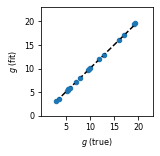

In [19]:
plt.figure(figsize=(2, 2))
plt.plot(truth_df["gain"].sort_values(), truth_df["gain"].sort_values(), "k--")
plt.scatter(truth_df["gain"], fit_df["gain_mean"], s=20)
plt.errorbar(truth_df["gain"], fit_df["gain_mean"],
             yerr=(fit_df["gain_mean"] - fit_df["gain_ll"], fit_df["gain_ul"] - fit_df["gain_mean"]),
             fmt="o", ms=3, color="C0", mfc="C0", mec="C0", ecolor="C0", capsize=2)
plt.xlim(0, 23)
plt.ylim(0, 23)
plt.xticks([5, 10, 15, 20], fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel("$g$ (true)", fontsize=8)
plt.ylabel("$g$ (fit)", fontsize=8)
# plt.savefig("/home/ordabayev/repos/tapqir-overleaf/extended-data/figure2/gain.svg")
plt.show()

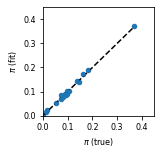

In [20]:
plt.figure(figsize=(2, 2))
plt.plot(truth_df["pi"].sort_values(), truth_df["pi"].sort_values(), "k--")
plt.scatter(truth_df["pi"], fit_df["pi_mean"], s=20)
plt.errorbar(truth_df["pi"], fit_df["pi_mean"],
             yerr=(fit_df["pi_mean"] - fit_df["pi_ll"], fit_df["pi_ul"] - fit_df["pi_mean"]),
             fmt="o", ms=3, color="C0", mfc="C0", mec="C0", ecolor="C0", capsize=2)

plt.xlim(0, 0.45)
plt.ylim(0, 0.45)
plt.xticks([0, 0.1, 0.2, 0.3, 0.4], fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel(r"$\pi$ (true)", fontsize=8)
plt.ylabel(r"$\pi$ (fit)", fontsize=8)
# plt.savefig("/home/ordabayev/repos/tapqir-overleaf/extended-data/figure2/pi.svg")
plt.show()

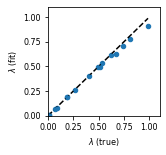

In [21]:
plt.figure(figsize=(2, 2))
plt.plot(truth_df["lamda"].sort_values(), truth_df["lamda"].sort_values(), "k--")
plt.scatter(truth_df["lamda"], fit_df["lamda_mean"], s=20)
plt.errorbar(truth_df["lamda"], fit_df["lamda_mean"],
             yerr=(fit_df["lamda_mean"] - fit_df["lamda_ll"], fit_df["lamda_ul"] - fit_df["lamda_mean"]),
             fmt="o", ms=3, color="C0", mfc="C0", mec="C0", ecolor="C0", capsize=2)

plt.xlim(0, 1.1)
plt.ylim(0, 1.1)
plt.xticks([0, 0.25, 0.5, 0.75, 1], fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel(r"$\lambda$ (true)", fontsize=8)
plt.ylabel(r"$\lambda$ (fit)", fontsize=8)
# plt.savefig("/home/ordabayev/repos/tapqir-overleaf/extended-data/figure2/lamda.svg")
plt.show()

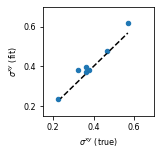

In [18]:
plt.figure(figsize=(2, 2))
plt.plot(truth_df["proximity"].sort_values(), truth_df["proximity"].sort_values(), "k--")
plt.scatter(truth_df["proximity"], fit_df["proximity_mean"], s=20)
plt.errorbar(truth_df["proximity"], fit_df["proximity_mean"],
             yerr=(fit_df["proximity_mean"] - fit_df["proximity_ll"], fit_df["proximity_ul"] - fit_df["proximity_mean"]),
             fmt="o", ms=3, color="C0", mfc="C0", mec="C0", ecolor="C0", capsize=2)

plt.xlim(0.15, 0.7)
plt.ylim(0.15, 0.7)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel(r"$\sigma^{xy}$ (true)", fontsize=8)
plt.ylabel(r"$\sigma^{xy}$ (fit)", fontsize=8)
# plt.savefig("/home/ordabayev/repos/tapqir-overleaf/extended-data/figure2/proximity.svg")
plt.show()

In [4]:
from tapqir.distributions import AffineBeta

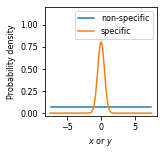

In [14]:
plt.figure(figsize=(2, 2))
x = torch.arange(-7.5, 7.5, 0.1)
d1 = AffineBeta(0, 2, -7.5, 7.5)
d2 = AffineBeta(0, 230, -7.5, 7.5)
plt.plot(x, d1.log_prob(x).exp(), label="non-specific")
plt.plot(x, d2.log_prob(x).exp(), label="specific")
plt.xlabel(r"$x$ or $y$", fontsize=8)
plt.ylabel("Probability density", fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.ylim(-0.03, 1.2)
plt.legend(fontsize=8)
plt.savefig("/tmp/prior.svg")
plt.show()